In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import MySQLdb as db
from pandas.io import sql
from sqlalchemy import create_engine
import datetime
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.tsatools import lagmat
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score
import dask.dataframe as dd
%matplotlib inline

In [70]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
train_df = pd.read_csv('train_1.csv')
key_df = pd.read_csv('key_1.csv')
sample_sub = pd.read_csv('sample_submission_1.csv')
train_df = train_df.fillna(0)
cols = list(train_df.columns.values)
cols = cols.remove('Page')
#flattened_df = pd.melt(train_df[list(train_df.columns[-50:]) + ['Page']],id_vars='Page',value_vars=cols)
#flattened_df.columns = ['Page','Date','Visits']
#print(flattened_df.head())

In [3]:
months = []
years = []
dates = []
for x in flattened_df['Date'].values: 
    datee = datetime.datetime.strptime(str(x), "%Y-%m-%d")
    months.append(datee.month)
    years.append(datee.year)
    dates.append(datee.day)
np.array(months)
np.array(years)
np.array(dates)

flattened_df['month'] = months
flattened_df['year'] = years
flattened_df['date'] = dates
flattened_df['Date'] = flattened_df['Date'].astype('datetime64[ns]')

In [4]:
print(flattened_df.head())
print(flattened_df['year'].unique())
flattened_df.reset_index(drop=False,inplace=True)

                                                Page       Date  Visits  \
0            2NE1_zh.wikipedia.org_all-access_spider 2016-11-12    13.0   
1             2PM_zh.wikipedia.org_all-access_spider 2016-11-12    12.0   
2              3C_zh.wikipedia.org_all-access_spider 2016-11-12     6.0   
3         4minute_zh.wikipedia.org_all-access_spider 2016-11-12    38.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s... 2016-11-12    13.0   

   month  year  date  
0     11  2016    12  
1     11  2016    12  
2     11  2016    12  
3     11  2016    12  
4     11  2016    12  
[2016]


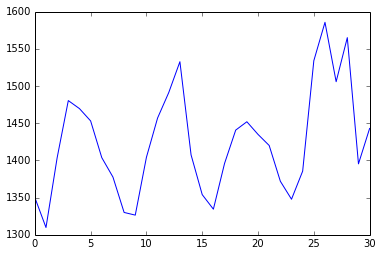

In [5]:
avg = flattened_df[['Page','date','Visits']].groupby(['date']).mean()
plt.plot(avg)
plt.show()

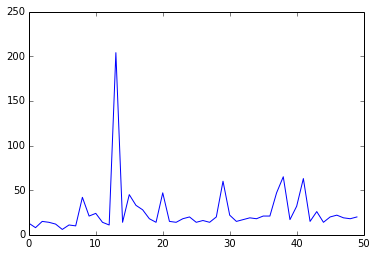

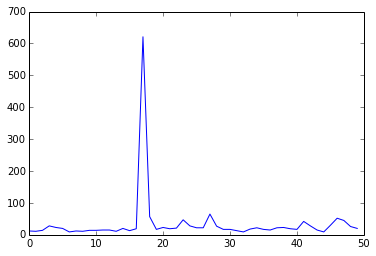

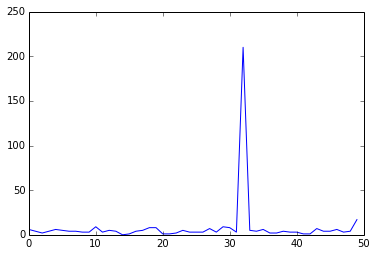

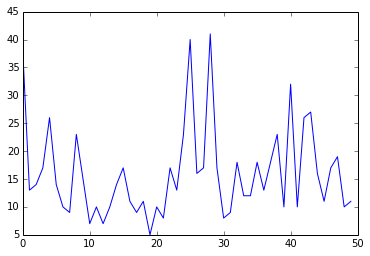

In [6]:
pages = ['2NE1_zh.wikipedia.org_all-access_spider','2PM_zh.wikipedia.org_all-access_spider','3C_zh.wikipedia.org_all-access_spider','4minute_zh.wikipedia.org_all-access_spider']
for item in pages :
    per_page = flattened_df[flattened_df['Page'] == item]
    page_avg = per_page[['Page','Date','Visits']].groupby('Date').mean()
    plt.plot(page_avg)
    plt.show()

In [7]:
flattened_df['weekday'] = flattened_df['Date'].apply(lambda x : x.weekday())
print(flattened_df.head())

   index                                               Page       Date  \
0      0            2NE1_zh.wikipedia.org_all-access_spider 2016-11-12   
1      1             2PM_zh.wikipedia.org_all-access_spider 2016-11-12   
2      2              3C_zh.wikipedia.org_all-access_spider 2016-11-12   
3      3         4minute_zh.wikipedia.org_all-access_spider 2016-11-12   
4      4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s... 2016-11-12   

   Visits  month  year  date  weekday  
0    13.0     11  2016    12        5  
1    12.0     11  2016    12        5  
2     6.0     11  2016    12        5  
3    38.0     11  2016    12        5  
4    13.0     11  2016    12        5  


In [8]:
time_series_mean = flattened_df[['Page','Date','Visits']].groupby('Date')['Visits'].mean()
input_df = pd.DataFrame(time_series_mean).reset_index(drop=False)
input_df['weekday'] = input_df['Date'].apply(lambda x : x.weekday())

print(input_df.head())

        Date       Visits  weekday
0 2016-11-12  1491.626266        5
1 2016-11-13  1625.662602        6
2 2016-11-14  1650.061015        0
3 2016-11-15  1514.151238        1
4 2016-11-16  1473.522090        2


In [9]:
months = []
years = []
dates = []
for x in input_df['Date'].values: 
    datee = datetime.datetime.strptime(str(x), "%Y-%m-%dT%H:%M:%S.%f000")
    months.append(datee.month)
    years.append(datee.year)
    dates.append(datee.day)
np.array(months)
np.array(years)
np.array(dates)

input_df['month'] = months
input_df['year'] = years
input_df['date'] = dates

In [10]:
print(input_df.head())

        Date       Visits  weekday  month  year  date
0 2016-11-12  1491.626266        5     11  2016    12
1 2016-11-13  1625.662602        6     11  2016    13
2 2016-11-14  1650.061015        0     11  2016    14
3 2016-11-15  1514.151238        1     11  2016    15
4 2016-11-16  1473.522090        2     11  2016    16


In [11]:
def add_diff(input_df) :
    input_df['diff'] = np.nan
    input_df.ix[1:,'diff'] = input_df.iloc[1:,1].as_matrix() - input_df.iloc[:len(input_df)-1,1].as_matrix()
    return input_df
    
df = add_diff(input_df)
print(df.head())


        Date       Visits  weekday  month  year  date        diff
0 2016-11-12  1491.626266        5     11  2016    12         NaN
1 2016-11-13  1625.662602        6     11  2016    13  134.036336
2 2016-11-14  1650.061015        0     11  2016    14   24.398413
3 2016-11-15  1514.151238        1     11  2016    15 -135.909777
4 2016-11-16  1473.522090        2     11  2016    16  -40.629147


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
def find_lag(df,lag) :
    x  = lagmat(df['diff'],lag)
    for c in range(1,lag+1) :
        df["lag%d"%c] = x[:,c-1]
    return df

lag = 7
#print(df.head())
lagged = find_lag(df,lag)
#print(lagged.head())
last_date = lagged['Date'].max()
print(last_date)

2016-12-31 00:00:00


In [13]:
train, test = train_test_split(lagged, test_size=0.3)
y_train = train[(8):]['diff']
x_train = train[(8):][:].drop(['Date','diff'],axis=1)
y_test = test[(8):]['diff']
x_test = test[(8):][:].drop(['Date','diff'],axis=1)


In [14]:
clf = LinearRegression()
x_train = x_train.fillna(0)
y_train = y_train.fillna(0)
x_test = x_test.fillna(0)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
acc_score = round(clf.score(x_train,y_train) * 100, 2)
print(acc_score)
print(x_train.head())

87.4
         Visits  weekday  month  year  date        lag1        lag2  \
40  1357.067109        3     12  2016    22  -81.441257  -54.600636   
15  1535.686040        6     11  2016    27  147.033813  -46.415061   
25  1403.695774        2     12  2016     7  -16.560005  -10.789815   
17  1490.116563        1     11  2016    29 -115.033696  101.928314   
1   1625.662602        6     11  2016    13    0.000000    0.000000   

          lag3        lag4       lag5       lag6        lag7  
40   85.057086  188.307349  14.645988 -66.271454 -114.517072  
15  -67.363511  -82.512970  -0.415874  47.406734   77.065275  
25   76.842193   93.753321 -40.330298  -9.399475 -130.585208  
17  147.033813  -46.415061 -67.363511 -82.512970   -0.415874  
1     0.000000    0.000000   0.000000   0.000000    0.000000  


TypeError: __init__() got multiple values for keyword argument 'handles'

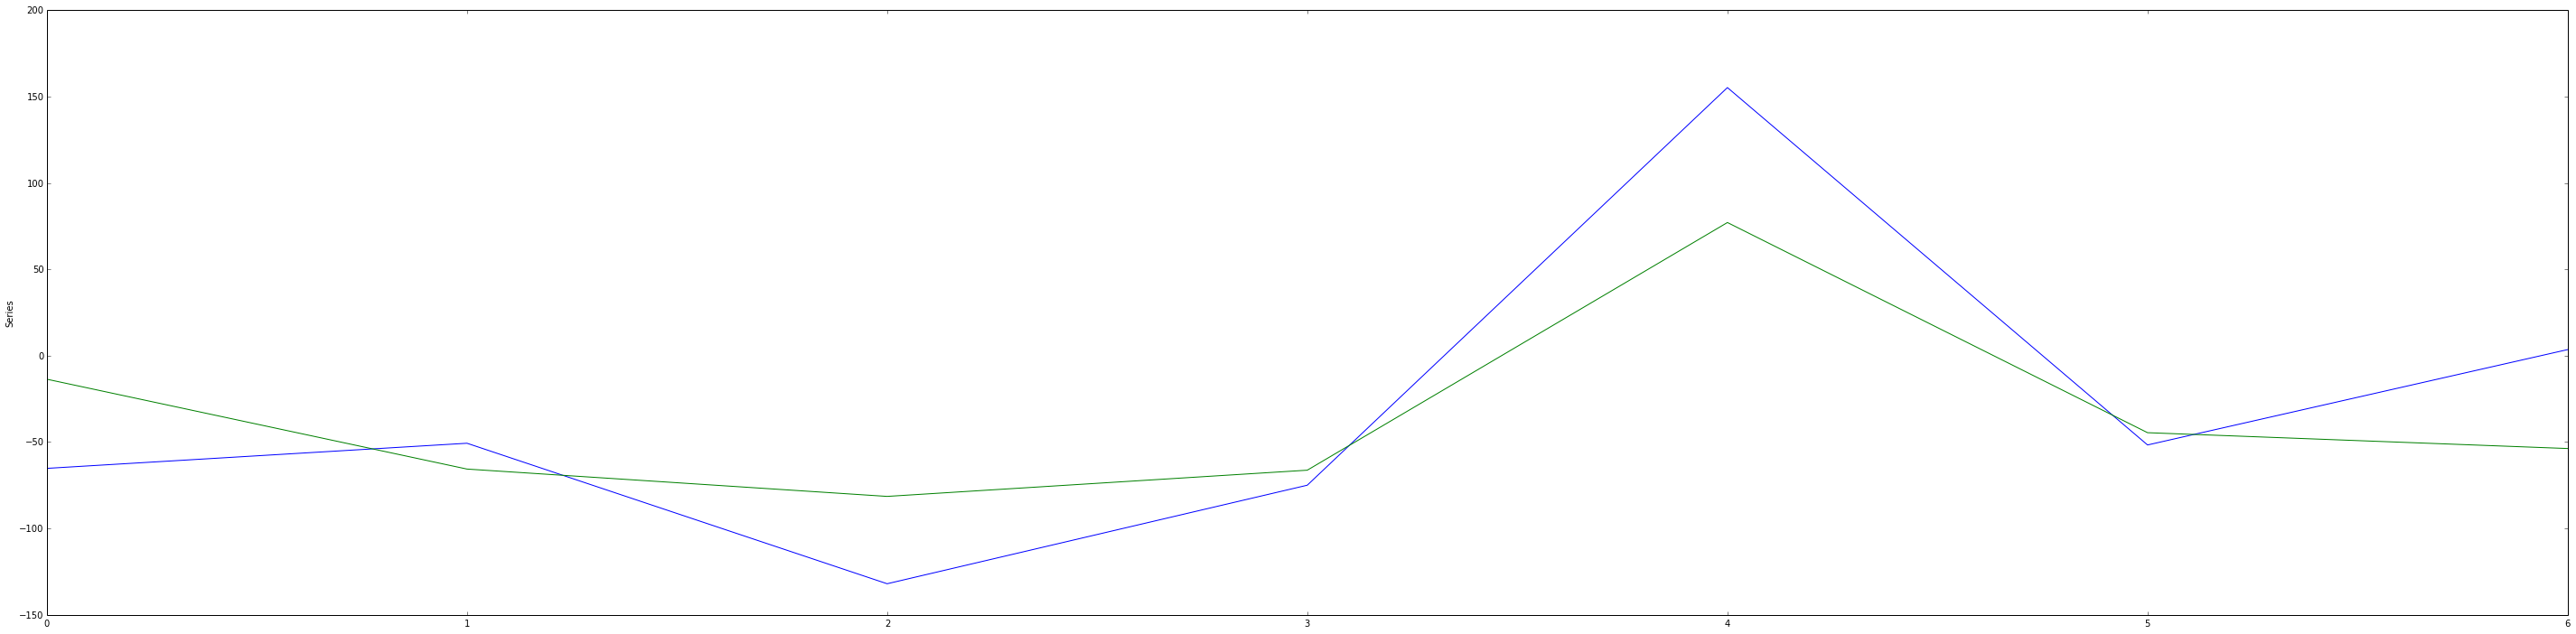

In [15]:
#plt.style.use('ggplot')
plt.figure(figsize=(50, 12))
line_up, = plt.plot(pred,label='Prediction')
line_down, = plt.plot(np.array(y_test),label='Reality')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down])
plt.title('Performance of predictions - Benchmark Predictions vs Reality')
plt.show()

In [ ]:
def find_data(df,ndays) :
    pred_df = pd.DataFrame(pd.Series(df['Date'][df.shape[0]-1] + timedelta(days=1)),columns=['Date'])
    for i in range(ndays) :
        inter = pd.DataFrame(pd.Series(df['Date'][df.shape[0]-1] + timedelta(days=i+2)),columns=['Date'])
        pred_df = pd.concat([pred_df,inter]).reset_index(drop=True)
    return pred_df

last_date = df['Date'].tail(1)
pred_data = find_data(df,30)
#print(pred_data)
#print(last_date)


In [ ]:
def initialisation(data_lag, data_pred, clf, xtrain, ytrain, number_of_days):
    # Initialisation
    clf.fit(xtrain, ytrain)
    for i in range(number_of_days-1) :
        lag1 = data_lag.tail(1)['diff'].values[0]
        lag2 = data_lag.tail(1)['lag1'].values[0]
        lag3 = data_lag.tail(1)['lag2'].values[0]
        lag4 = data_lag.tail(1)['lag3'].values[0]
        lag5 = data_lag.tail(1)['lag4'].values[0]
        lag6 = data_lag.tail(1)['lag5'].values[0]
        lag7 = data_lag.tail(1)['lag6'].values[0]
        #lag8 = data_lag.tail(1)['lag7'].values[0]
        data_pred['weekday'] = data_pred['Date'].apply(lambda x : x.weekday())
        weekday = data_pred['weekday'][0]
        last_visit = data_lag.tail(1)['Visits'].values[0]
        Date = data_pred['Date'][0]
        datee = datetime.datetime.strptime(str(Date), "%Y-%m-%d %H:%M:%S")
        month = datee.month
        year = datee.year
        date = datee.day
        
        to_pred = pd.DataFrame(columns=['Visits','weekday','month','year','date','lag1','lag2','lag3','lag4','lag5','lag6','lag7'])
        row = pd.Series([last_visit,weekday,month,year,date,lag1,lag2,lag3,lag4,lag5,lag6,lag7],['Visits','weekday','month','year','date','lag1','lag2','lag3','lag4','lag5','lag6','lag7'])
        to_pred = to_pred.append([row])
        prediction = pd.DataFrame(clf.predict(to_pred),columns = ['diff'])
        #print prediction
        data_lag = pd.concat([data_lag,prediction.join(data_pred["Date"]).join(to_pred)]).reset_index(drop=True)
        data_lag['Visits'][data_lag.shape[0]-1] = last_visit + prediction['diff'][0]
        data_pred = data_pred[data_pred['Date'] > data_pred['Date'][0]].reset_index(drop=True)
    return data_lag

clf = AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)
lagged = initialisation(lagged, pred_data, clf, x_train, y_train, 30)
print(lagged.tail())

In [ ]:
lagged = lagged.loc[lagged['Visits'] < 0,'Visits'] = 0

In [ ]:
#print(lagged.())
df_total = lagged[['Visits','Date']]
#print(df_total.tail())
#print(last_date)
df_train = df_total[df_total['Date'] <= last_date]
#print(df_train.tail())
df_test = df_total[df_total['Date'] >= last_date]
#print(df_test.tail())
plt.figure(figsize=(30,5))
plt.ylim(0,3000)
plt.plot(df_train.Date,df_train.Visits,color='b')
plt.plot(df_test.Date,df_test.Visits,color='r')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')

plt.show()

    

In [38]:
print(flattened_df.head())

   index                                               Page       Date  \
0      0            2NE1_zh.wikipedia.org_all-access_spider 2016-11-12   
1      1             2PM_zh.wikipedia.org_all-access_spider 2016-11-12   
2      2              3C_zh.wikipedia.org_all-access_spider 2016-11-12   
3      3         4minute_zh.wikipedia.org_all-access_spider 2016-11-12   
4      4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s... 2016-11-12   

   Visits  month  year  date  weekday  
0    13.0     11  2016    12        5  
1    12.0     11  2016    12        5  
2     6.0     11  2016    12        5  
3    38.0     11  2016    12        5  
4    13.0     11  2016    12        5  


In [42]:
analysis_df = flattened_df[['year','Visits']]
print(analysis_df.head())
print(analysis_df.index)

   year  Visits
0  2016    13.0
1  2016    12.0
2  2016     6.0
3  2016    38.0
4  2016    13.0
RangeIndex(start=0, stop=7253150, step=1)


In [57]:
plot_df = flattened_df[['month','Visits']].groupby('month').mean()
print(plot_df)
#plt.plot(plot_df)
#plt.show(plot_df.index,plot_df.Visits)

            Visits
month             
11     1450.038333
12     1420.107343


In [71]:

cols = list(train_df.columns.values)
cols = cols.remove('Page')
flattened_df = pd.melt(train_df[list(train_df,id_vars='Page',value_vars=cols))



SyntaxError: invalid syntax (<ipython-input-71-f9648c14d11b>, line 4)

In [6]:
train_df = dd.read_csv('train_1.csv')
#print(train_df.head())
cols = list(train_df.columns.values)
cols = cols.remove('Page')
flattened_df = pd.melt(train_df[list(train_df,id_vars='Page',value_vars=cols)])
print(flattened_df.head())

TypeError: list() takes at most 1 argument (3 given)